In [17]:
# from google.colab import drive
# drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:

# #file saving location
images_dir = '../mel_spectro_fix_dim/'

In [3]:
import os
import glob
from PIL import Image

All images are of Width: 137 Height: 47


In [4]:
for digit in range(1):
    # Directory of wav files
    folder_path = f"{images_dir}{digit}/"
    file_list = glob.glob(os.path.join(folder_path, '*'))

    for i, img_path  in enumerate(file_list):
    #   # Open the image file
      image = Image.open(f"{img_path}")


    #   # Get the size of the image
      width, height = image.size

      print(f"Width: {width} Height: {height}")

              

Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47
Width: 137 Height: 47


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:

img_width, img_height = 137, 47
batch_size = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    images_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    images_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    images_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 195 images belonging to 10 classes.
Found 45 images belonging to 10 classes.
Found 240 images belonging to 10 classes.


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [34]:
epochs = 100
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100,restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=[early_stopping_cb])




Epoch 1/100
24/24 [==============================] - 7s 231ms/step - loss: 2.3048 - accuracy: 0.1070 - val_loss: 2.2401 - val_accuracy: 0.1500
Epoch 2/100
24/24 [==============================] - 4s 155ms/step - loss: 2.2438 - accuracy: 0.1765 - val_loss: 2.1721 - val_accuracy: 0.2500
Epoch 3/100
24/24 [==============================] - 6s 250ms/step - loss: 2.0181 - accuracy: 0.2995 - val_loss: 2.0305 - val_accuracy: 0.2750
Epoch 4/100
24/24 [==============================] - 4s 182ms/step - loss: 2.0033 - accuracy: 0.3529 - val_loss: 1.8104 - val_accuracy: 0.3250
Epoch 5/100
24/24 [==============================] - 4s 158ms/step - loss: 1.8534 - accuracy: 0.3422 - val_loss: 1.9614 - val_accuracy: 0.3000
Epoch 6/100
24/24 [==============================] - 5s 216ms/step - loss: 1.9338 - accuracy: 0.3102 - val_loss: 1.8936 - val_accuracy: 0.2750
Epoch 7/100
24/24 [==============================] - 4s 149ms/step - loss: 1.7623 - accuracy: 0.3281 - val_loss: 1.9962 - val_accuracy: 0.1750

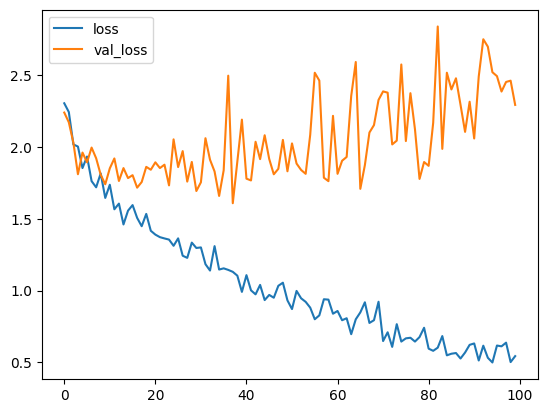

In [35]:
#plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

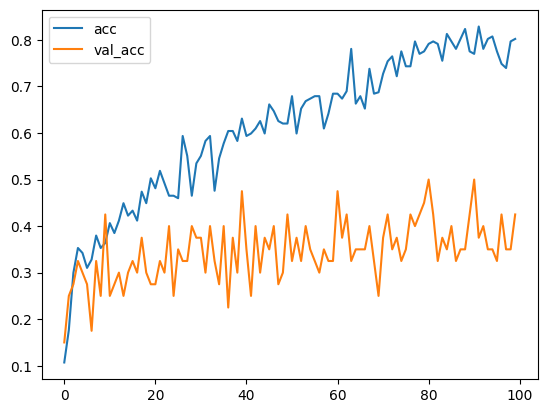

In [36]:
#plot accuracy per iteration
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

Data is not converging and overfitting. This is the same for batch size 32, 16, 8. May be more epochs will make some changes. 

In [37]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n//test_generator.batch_size)
print('Test accuracy:', test_acc)


30/30 [==============================] - 1s 40ms/step - loss: 0.6520 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


But gave for given test case 83% accuracy.

In [39]:
import numpy as np
import tensorflow as tf

validation_generator.reset()  # reset the generator to the beginning of the validation dataset

predictions = model.predict(validation_generator, steps=validation_generator.n//validation_generator.batch_size+1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Predictions:', predicted_classes)
print('True classes:', true_classes)

# Compute the confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes)

# Print the confusion matrix
print('Confusion matrix:')
print(confusion_matrix)



6/6 [==============================] - 1s 142ms/step
Predictions: [1 2 4 7 0 9 8 5 4 9 1 5 4 8 9 9 2 7 9 9 0 8 3 1 4 2 6 5 3 4 1 4 5 1 7 4 7
 8 1 6 2 1 0 7 1]
True classes: [0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 4 5 5 5 5 6 6 6 6 6 7 7 7 7 8 8
 8 8 8 9 9 9 9 9]
Confusion matrix:
tf.Tensor(
[[0 1 1 0 1 0 0 1 0 0]
 [1 0 0 0 1 1 0 0 1 2]
 [0 1 0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 2]
 [1 0 0 0 0 0 0 1 1 2]
 [0 1 1 1 1 0 0 0 0 0]
 [0 1 0 1 1 1 1 0 0 0]
 [0 1 0 0 1 1 0 1 0 0]
 [0 1 0 0 1 0 1 1 1 0]
 [1 2 1 0 0 0 0 1 0 0]], shape=(10, 10), dtype=int32)
